# Boltzmann Generators: Muller-Brown Potential

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../Library")

import os
import potentials
import sampling
import training
import visuals
import generator
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
import warnings
import torch 
from torch import distributions
from torch import nn
from torch.utils import data
from tqdm.auto import tqdm
from sklearn import datasets

# warnings.filterwarnings('ignore')

# torch.set_default_tensor_type('torch.cuda.FloatTensor')
rc('font', **{
    'family': 'sans-serif',
    'sans-serif': ['DejaVu Sans'],
    'size': 10
})
# Set the font used for MathJax - more on this later
rc('mathtext', **{'default': 'regular'})
plt.rc('font', family='serif')
%matplotlib inline

In [3]:
np.random.seed(seed=3)
torch.manual_seed(3)

## Potential

In [4]:
muller = potentials.MullerBrownPotential(alpha = 0.1,
                             A = [-200, -100, -170, 15],
                             a = [-1, -1, -6.5, 0.7],
                             b = [0, 0, 11, 0.6],
                             c = [-10, -10, -6.5, 0.7],
                             x_j = [1, 0, -0.5, -1],
                             y_j = [0, 0.5, 1.5, 1]
                            )

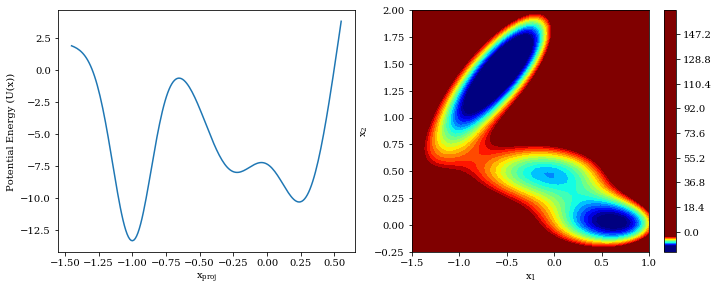

In [5]:
# Project xy coordinates to the (1, -1) vector
x_data = np.linspace(-1.2, 0.8, 200)
y_data = -x_data + 0.5
xy_data = np.array([x_data, y_data]).T
x_proj = np.dot(xy_data, np.array([1, -1]))/np.dot(np.array([1,-1]),np.array([1,-1]))

U = [muller.get_energy(np.array([a,b])) for a,b in zip(x_data, y_data)]
fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize=[10,4])
ax[0].plot(x_proj, U)
ax[0].set_xlabel("$x_{proj}$")
ax[0].set_ylabel("Potential Energy (U(x))")
visuals.plot_2D_potential(muller.get_energy, xlim = [-1.5, 1], ylim = [-0.25, 2], cmap = 'jet')
fig.tight_layout(pad=0.5)

## Sampling

In [6]:
# Simulation Parameters
T = 1
sigma = 0.02
x0_1 = np.array([-0.5,1.5])
x0_2 = np.array([-0.1, 0.5])
x0_3 = np.array([1.0, 0.0])
n_steps = 10000
out_freq = 10

In [7]:
# Sampling meta-state 1
system_mp1 = sampling.MetropolisSampler(muller, temp = 1, sigma = 0.02, stride = out_freq)
system_mp1.run(x0_1, n_steps)

In [8]:
# Sampling meta-state 2

system_mp2 = sampling.MetropolisSampler(muller, temp = 1, sigma = 0.02, stride = out_freq)
system_mp2.run(x0_2, n_steps)

In [9]:
# Sampling meta-state 3

system_mp3 = sampling.MetropolisSampler(muller, temp = 1, sigma = 0.02, stride = out_freq)
system_mp3.run(x0_3, n_steps)

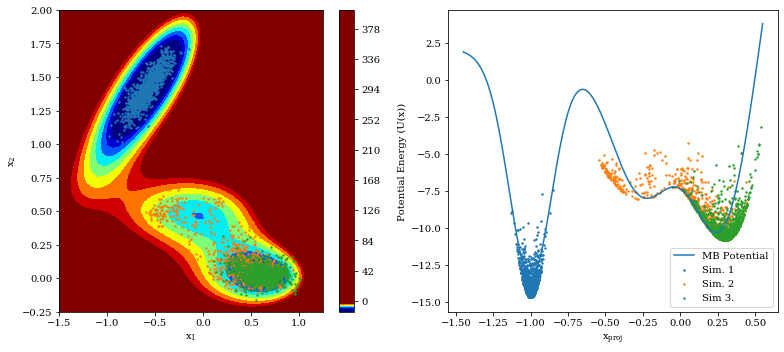

In [10]:
fig, ax = plt.subplots(1, 2, figsize = [11, 5])

# Sampling on potential surface
plt.subplot(1, 2, 1)
visuals.plot_2D_potential(muller.get_energy,  xlim = [-1.5, 1.25], ylim = [-0.25, 2], cmap = "jet")
plt.scatter(*np.array(system_mp1.xtraj).T, s=2)
plt.scatter(*np.array(system_mp2.xtraj).T, s=2)
plt.scatter(*np.array(system_mp3.xtraj).T, s=2)

# Projecting samples to x_proj
plt.subplot(1, 2, 2)
xy_mp1 = np.array(system_mp1.xtraj).squeeze()
x_proj_mp1 = np.dot(xy_mp1, np.array([1, -1]))/np.dot(np.array([1, -1]), np.array([1, -1]))
xy_mp2 = np.array(system_mp2.xtraj).squeeze()
x_proj_mp2 = np.dot(xy_mp2, np.array([1, -1]))/np.dot(np.array([1, -1]), np.array([1, -1]))
xy_mp3 = np.array(system_mp3.xtraj).squeeze()
x_proj_mp3= np.dot(xy_mp3, np.array([1, -1]))/np.dot([1,-1],[1,-1])

# Energy Sampling
plt.plot(x_proj, U)
plt.scatter(x_proj_mp1, system_mp1.etraj, s=2)
plt.scatter(x_proj_mp2, system_mp2.etraj, s=2)
plt.scatter(x_proj_mp3, system_mp3.etraj, s=2)
plt.xlabel("$x_{proj}$")
plt.ylabel("Potential Energy (U(x))")
plt.legend(["MB Potential", "Sim. 1", "Sim. 2", "Sim 3."])
fig.tight_layout()
plt.savefig("../Project/Pictures/muller_potential_sampling.jpg", dpi = 600)

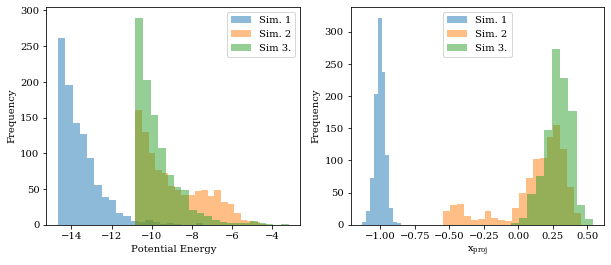

In [11]:
all_energy_mp = np.concatenate((system_mp1.etraj, system_mp2.etraj, system_mp3.etraj))
all_coords_mp = np.concatenate((x_proj_mp1, x_proj_mp2, x_proj_mp3))
fig, ax = plt.subplots(ncols=2, figsize=[10,4])
# hist1 = ax[0].hist(all_energy_mp, bins = 40)
ax[0].hist(system_mp1.etraj, bins = 20, alpha = 0.5)
ax[0].hist(system_mp2.etraj, bins = 20, alpha = 0.5)
ax[0].hist(system_mp3.etraj, bins = 20, alpha = 0.5)
ax[0].set_xlabel("Potential Energy")
ax[0].set_ylabel("Frequency")
ax[0].legend(["Sim. 1", "Sim. 2", "Sim 3."])
ax[1].hist(x_proj_mp1, bins = 10, alpha = 0.5)
ax[1].hist(x_proj_mp2, bins = 20, alpha = 0.5)
ax[1].hist(x_proj_mp3, bins = 10, alpha = 0.5)
ax[1].set_xlabel("$x_{proj}$")
ax[1].set_ylabel("Frequency")
ax[1].legend(["Sim. 1", "Sim. 2", "Sim 3."])


## Boltzmann Generator

In [12]:
# Dataset
x_samples = np.concatenate((xy_mp1, xy_mp2, xy_mp3))
np.random.shuffle(x_samples)

# RealNVP Parameters
n_blocks = 5  # number of NVP blocks (Divide by 2?)
dimension = 2    # dimensionality of the probability distributios (in real sapce and latent space)
n_hidden = 100   # number of nodes in each hidden layer
l_hidden = 3     # number of hidden layers 
n_iteration = 500
batch_size = 128
LR = 0.001     # learning rate

## ML Loss

Loading the trained ML model ...
Total loss: -2.159083366394043


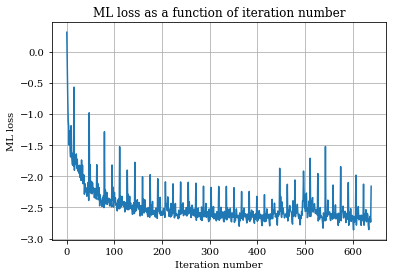

In [13]:
params_ML = {"n_blocks":     5,
             "dimension" :   2,
             "reshape" : (2, ),
             "n_nodes":    100,
             "n_layers":     3,
             "n_epochs":  40,
             "batch_size": 200,
             "LR":      0.001,
             "prior_sigma": 1}
w_loss = [1, 0, 0]

BoltzmannGenerator_ML = training.BoltzmannGenerator(model_params=params_ML)
model_ML = BoltzmannGenerator_ML.build(muller)

if os.path.isfile('Trained_models/Muller/model_ML') is True:  
    print("Loading the trained ML model ...")
    model_ML, loss = BoltzmannGenerator_ML.load(model_ML, 'Trained_models/Muller/model_ML')
else:   
    print("Training model_ML ...")
    BoltzmannGenerator_ML.train(model_ML, w_loss, x_samples=x_samples)
    BoltzmannGenerator_ML.save(model_ML, 'Trained_models/Muller/model_ML')
    loss = BoltzmannGenerator_ML.loss_iteration
    
# plot the loss function as a function of iteration
plt.figure()
plt.plot(range(len(loss)), loss)
plt.xlabel('Iteration number')
plt.ylabel('ML loss')
plt.title('ML loss as a function of iteration number')
plt.grid()
plt.savefig('../Project/Pictures/Muller_training_ML_loss.png', dpi=600)

In [14]:
from scipy.stats import multivariate_normal
def binormal_contour():
    x, y = np.mgrid[-3:3:.01, -3:3:.01]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    rv = multivariate_normal([0, 0], [[1, 0], [0, 1]])
    
    plt.contourf(x, y, rv.pdf(pos), 20)
    plt.xlabel('$ z_{1} $')
    plt.ylabel('$ z_{2} $')
    plt.title('Bivariate normal distribution')
    clb = plt.colorbar()
    clb.ax.set_title(r'$P(z)$')
    
    ax = plt.gca()
    ax.set_aspect('equal')

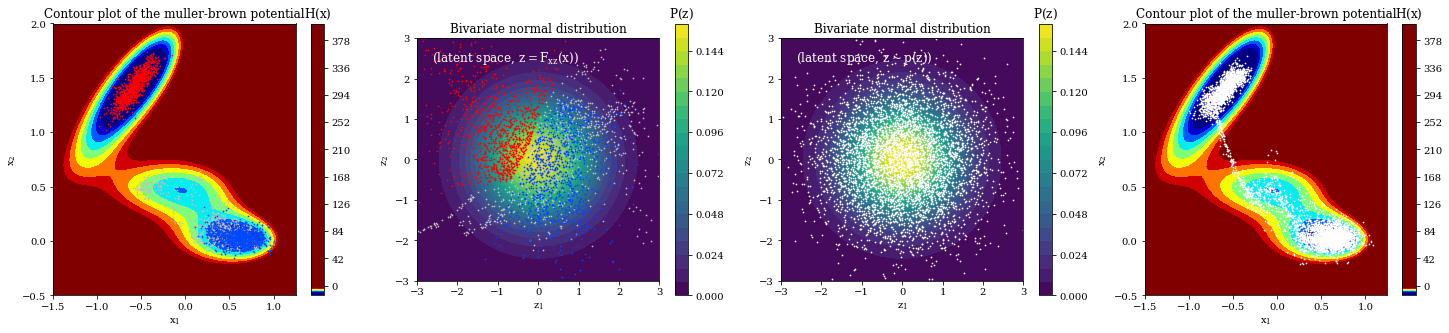

In [112]:
BoltzmannPlotter_ML = visuals.BoltzmannPlotter(muller, model_ML, [xy_mp1, xy_mp2, xy_mp3])
BoltzmannPlotter_ML.generator_result('../Project/Pictures/MBP_ML_result.png')

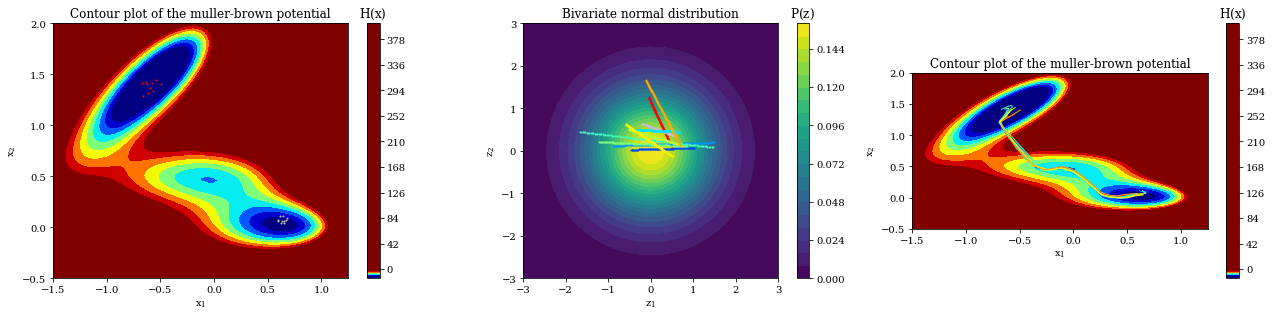

In [113]:
BoltzmannPlotter_ML.latent_interpolation('../Project/Pictures/DWP_ML_interpolation.png', x1 = xy_mp1[-10:], x2 = xy_mp3[-10:])

## KL Loss

Loading the trained KL model ...
Total loss: -8.611949920654297


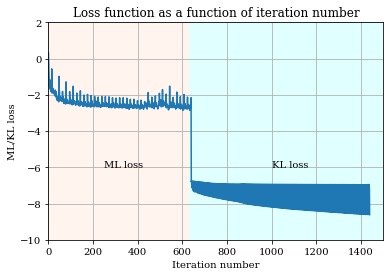

In [36]:
params_KL = {"n_blocks":     5,
             "dimension" :   2,
             "reshape" : (2, ),
             "n_nodes":    100,
             "n_layers":     3,
             "n_epochs":  200,
             "batch_size": 1000,
             "LR":      0.0001,
             "prior_sigma": 1}
w_loss = [0, 1, 0]

BoltzmannGenerator_KL = training.BoltzmannGenerator(model_params=params_KL)
model_KL = BoltzmannGenerator_KL.build(muller)
if os.path.isfile('Trained_models/Muller/model_KL') is True:  
    print("Loading the trained KL model ...")
    model_KL, loss = BoltzmannGenerator_KL.load(model_KL, 'Trained_models/Muller/model_KL')
elif os.path.isfile('Trained_models/Muller/model_ML') is True:
    print("Loading the trained ML model ...")
    model_KL, loss_ML = BoltzmannGenerator_KL.load(model_KL, 'Trained_models/Muller/model_ML')
    print("Training the KL model based on the trained ML model ...")
    z_samples = BoltzmannGenerator_KL.prior.sample_n(len(x_samples)).detach().numpy()  
    BoltzmannGenerator_KL.train(model_KL, w_loss, z_samples=z_samples)
    BoltzmannGenerator_KL.save(model_KL, 'Trained_models/Muller/model_KL', previous_loss=loss_ML)
    loss = BoltzmannGenerator_KL.loss_iteration  # ML loss will be appended to KL loss automatically by specifying previos_loss
else:
    print("Error! No parameter files of ML or KL model found.") 
    print("(Note: The Boltzmann should be trained on the ML loss before it is trained on KL loss.)")
    sys.exit()
    
# plot the loss function as a function of iteration
plt.figure()
plt.plot(range(len(loss)), loss)
plt.xlabel('Iteration number')
plt.ylabel('ML/KL loss')
plt.title('Loss function as a function of iteration number')
plt.grid()
plt.savefig('../Project/Pictures/MBP_training_KL_loss.png', dpi=600)

y = np.arange(-20,10)
plt.fill_betweenx(y, 0, 630, color='seashell', zorder = 0)
plt.fill_betweenx(y, 630, 1500, color='lightcyan', zorder = 0)
plt.text(250, -6, 'ML loss')
plt.text(1000, -6, 'KL loss')
plt.xlim([0, 1500])
plt.ylim([-10, 2])
plt.savefig('../Project/Pictures/MBP_training_KL_loss.png', dpi=600)

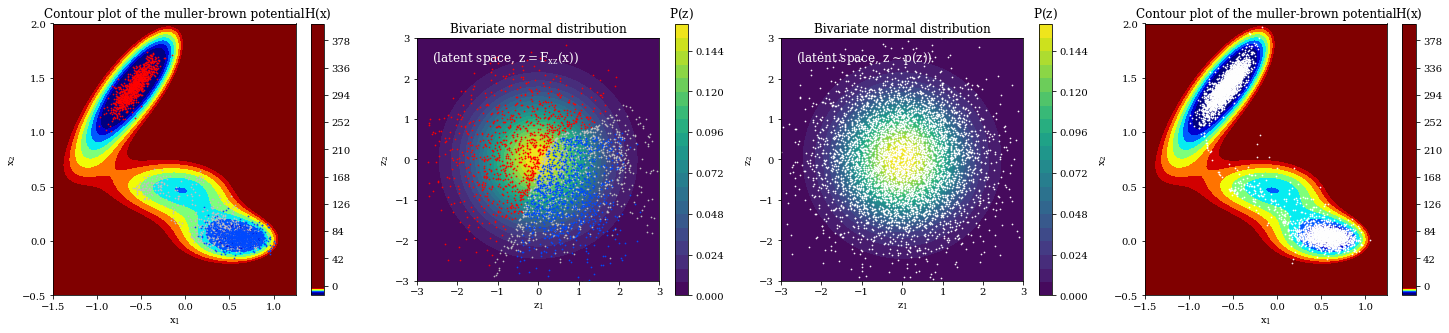

In [111]:
BoltzmannPlotter_KL = visuals.BoltzmannPlotter(muller, model_KL, [xy_mp1, xy_mp2, xy_mp3])
BoltzmannPlotter_KL.generator_result('../Project/Pictures/MBP_ML_result.png')

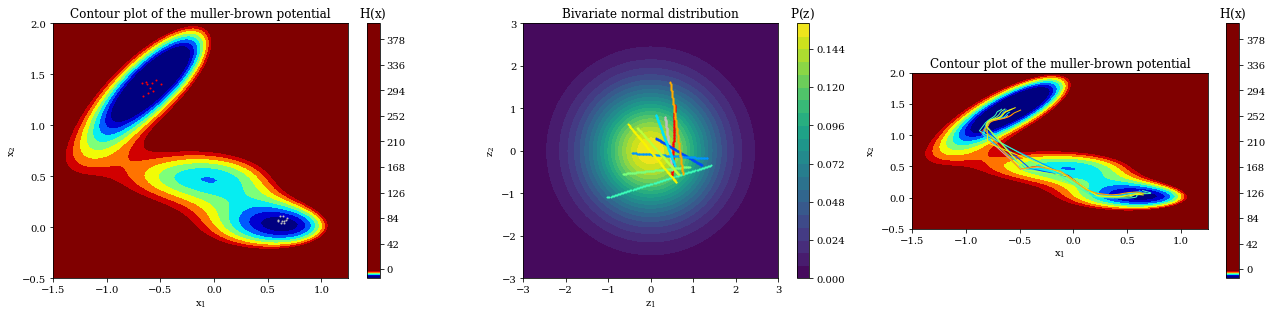

In [110]:
BoltzmannPlotter_KL.latent_interpolation('../Project/Pictures/DWP_KL_interpolation.png', x1 = xy_mp1[-10:], x2 = xy_mp3[-10:])

## KL + ML Loss

Loading the trained KL model ...
Total loss: -11.877113342285156


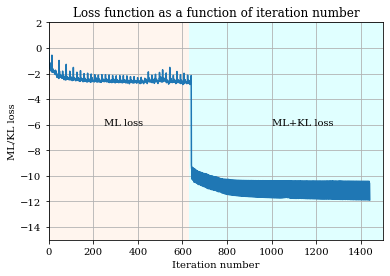

In [39]:
params_KL = {"n_blocks":     5,
             "dimension" :   2,
             "reshape" : (2, ),
             "n_nodes":    100,
             "n_layers":     3,
             "n_epochs":  200,
             "batch_size": 1000,
             "LR":      0.0001,
             "prior_sigma": 1}
w_loss = [1, 1, 0]

BoltzmannGenerator_MLKL = training.BoltzmannGenerator(model_params=params_KL)
model_MLKL = BoltzmannGenerator_MLKL.build(muller)
if os.path.isfile('Trained_models/Muller/model_MLKL') is True:  
    print("Loading the trained KL model ...")
    model_MLKL, loss = BoltzmannGenerator_MLKL.load(model_KL, 'Trained_models/Muller/model_MLKL')
elif os.path.isfile('Trained_models/Muller/model_ML') is True:
    print("Loading the trained ML model ...")
    model_MLKL, loss_ML = BoltzmannGenerator_MLKL.load(model_KL, 'Trained_models/Muller/model_ML')
    print("Training the KL model based on the trained ML model ...")
    z_samples = BoltzmannGenerator_KL.prior.sample_n(10002).detach().numpy()  
    BoltzmannGenerator_MLKL.train(model_KL, w_loss, z_samples=z_samples, x_samples = x_samples)
    BoltzmannGenerator_MLKL.save(model_KL, 'Trained_models/Muller/model_MLKL', previous_loss=loss_ML)
    loss = BoltzmannGenerator_MLKL.loss_iteration  # ML loss will be appended to KL loss automatically by specifying previos_loss
else:
    print("Error! No parameter files of ML or KL model found.") 
    print("(Note: The Boltzmann should be trained on the ML loss before it is trained on KL loss.)")
    sys.exit()
    
# plot the loss function as a function of iteration
plt.figure()
plt.plot(range(len(loss)), loss)
plt.xlabel('Iteration number')
plt.ylabel('ML/KL loss')
plt.title('Loss function as a function of iteration number')
plt.grid()
plt.savefig('../Project/Pictures/MBP_training_MLKL_loss.png', dpi=600)

y = np.arange(-20,10)
plt.fill_betweenx(y, 0, 630, color='seashell', zorder = 0)
plt.fill_betweenx(y, 630, 1500, color='lightcyan', zorder = 0)
plt.text(250, -6, 'ML loss')
plt.text(1000, -6, 'ML+KL loss')
plt.xlim([0, 1500])
plt.ylim([-15, 2])
plt.savefig('../Project/Pictures/MBP_training_MLKL_loss.png', dpi=600)

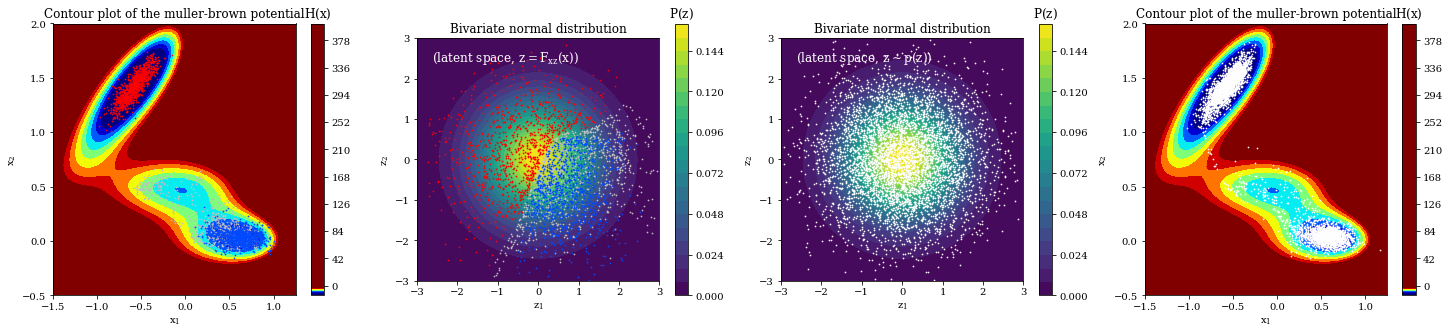

In [108]:
BoltzmannPlotter_MLKL = visuals.BoltzmannPlotter(muller, model_MLKL, [xy_mp1, xy_mp2, xy_mp3])
BoltzmannPlotter_MLKL.generator_result('../Project/Pictures/MBP_MLKL_result.png')

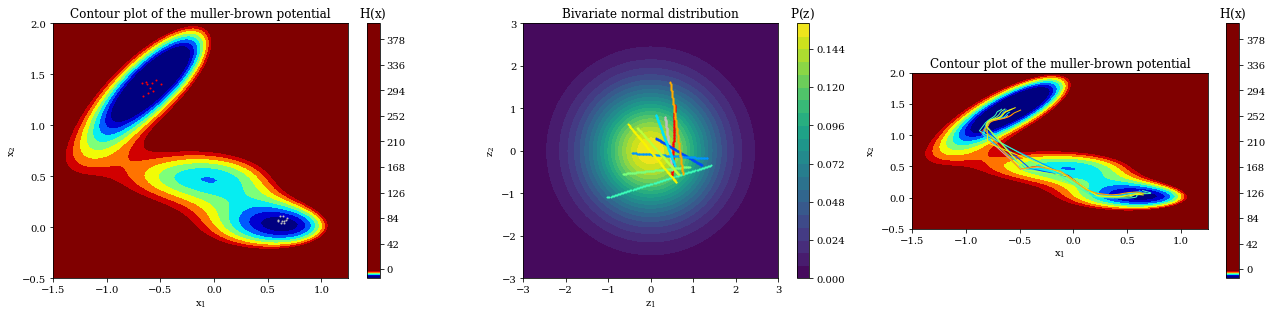

In [109]:
BoltzmannPlotter_MLKL.latent_interpolation('../Project/Pictures/DWP_MLKL_interpolation.png', x1 = xy_mp1[-10:], x2 = xy_mp3[-10:])

## ML + KL + RC Loss

Loading the trained ML model ...
Total loss: -2.159083366394043
Training the KL model based on the trained ML model ...


/home/lenny/anaconda3/lib/python3.7/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


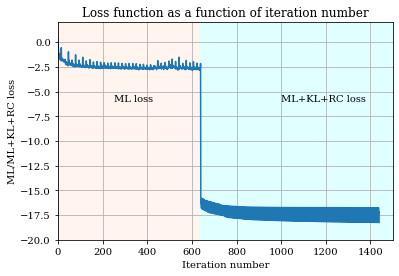

In [49]:
params_MLKLRC = {"n_blocks":     5,
             "dimension" :   2,
             "reshape" : (2, ),
             "n_nodes":    100,
             "n_layers":     3,
             "n_epochs":  200,
             "batch_size": 1000,
             "LR":      0.0001,
             "prior_sigma": 1}
w_loss = [1, 1, 1]

rxn_coordinate = lambda x: x[:, 1]

BoltzmannGenerator_MLKLRC = training.BoltzmannGenerator(model_params=params_MLKLRC)
model_MLKLRC = BoltzmannGenerator_MLKLRC.build(muller)
if os.path.isfile('Trained_models/Muller/model_MLKLRC') is True:  
    print("Loading the trained MLKLRC model ...")
    model_MLKLRC, loss = BoltzmannGenerator_MLKLRC.load(model_MLKLRC, 'Trained_models/Muller/model_MLKLRC')
elif os.path.isfile('Trained_models/Muller/model_ML') is True:
    print("Loading the trained ML model ...")
    model_MLKLRC, loss_ML = BoltzmannGenerator_MLKLRC.load(model_MLKLRC, 'Trained_models/Muller/model_ML')
    print("Training the KL model based on the trained ML model ...")
    z_samples = BoltzmannGenerator_MLKLRC.prior.sample_n(10002).detach().numpy()  
    BoltzmannGenerator_MLKLRC.train(model_MLKLRC, w_loss, z_samples=z_samples, x_samples = x_samples, rxn_coordinate = rxn_coordinate)
    BoltzmannGenerator_MLKLRC.save(model_MLKLRC, 'Trained_models/Muller/model_MLKLRC', previous_loss=loss_ML)
    loss = BoltzmannGenerator_MLKLRC.loss_iteration  # ML loss will be appended to KL loss automatically by specifying previos_loss
else:
    print("Error! No parameter files of ML or KL model found.") 
    print("(Note: The Boltzmann should be trained on the ML loss before it is trained on KL loss.)")
    sys.exit()
    
# plot the loss function as a function of iteration
plt.figure()
plt.plot(range(len(loss)), loss)
plt.xlabel('Iteration number')
plt.ylabel('ML/ML+KL+RC loss')
plt.title('Loss function as a function of iteration number')
plt.grid()
plt.savefig('../Project/Pictures/MBP_training_MLKLRC_loss.png', dpi=600)

y = np.arange(-20,10)
plt.fill_betweenx(y, 0, 630, color='seashell', zorder = 0)
plt.fill_betweenx(y, 630, 1500, color='lightcyan', zorder = 0)
plt.text(250, -6, 'ML loss')
plt.text(1000, -6, 'ML+KL+RC loss')
plt.xlim([0, 1500])
plt.ylim([-20, 2])
plt.savefig('../Project/Pictures/MBP_training_MLKLRC_loss.png', dpi=600)

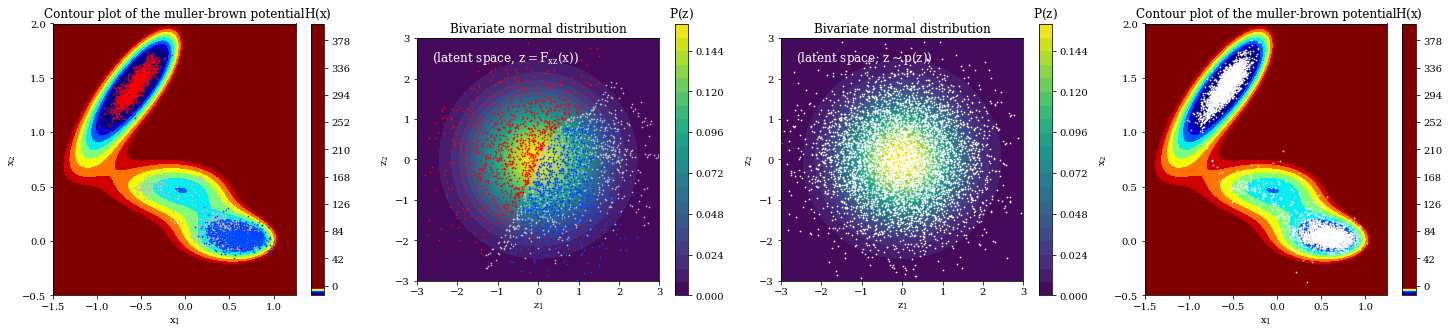

In [107]:
BoltzmannPlotter_MLKLRC = visuals.BoltzmannPlotter(muller, model_MLKLRC, [xy_mp1, xy_mp2, xy_mp3])
BoltzmannPlotter_MLKLRC.generator_result('../Project/Pictures/MBP_MLKLRC_result.png')

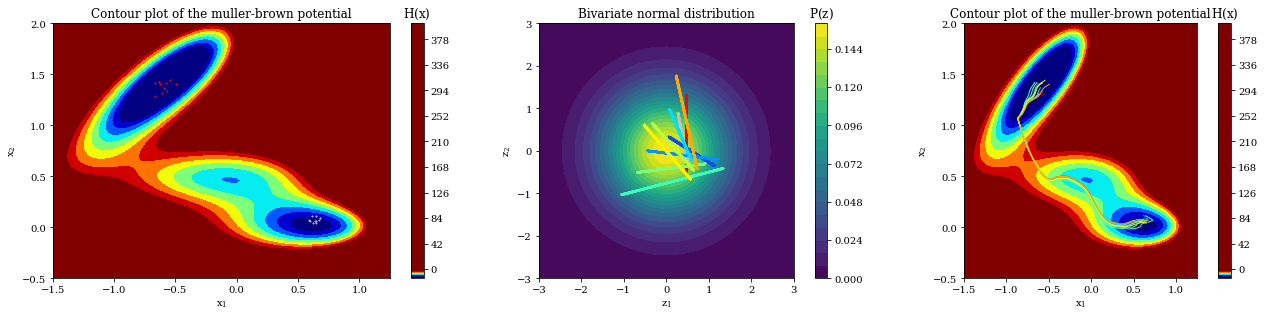

In [125]:
BoltzmannPlotter_MLKLRC.latent_interpolation('../Project/Pictures/MBP_MLKLRC_interpolation.png', x1 = xy_mp1[-10:], x2 = xy_mp3[-10:])
plt.tight_layout()

In [ ]:
BoltzmannGenerator_MLKLRC.free_energy_profile()

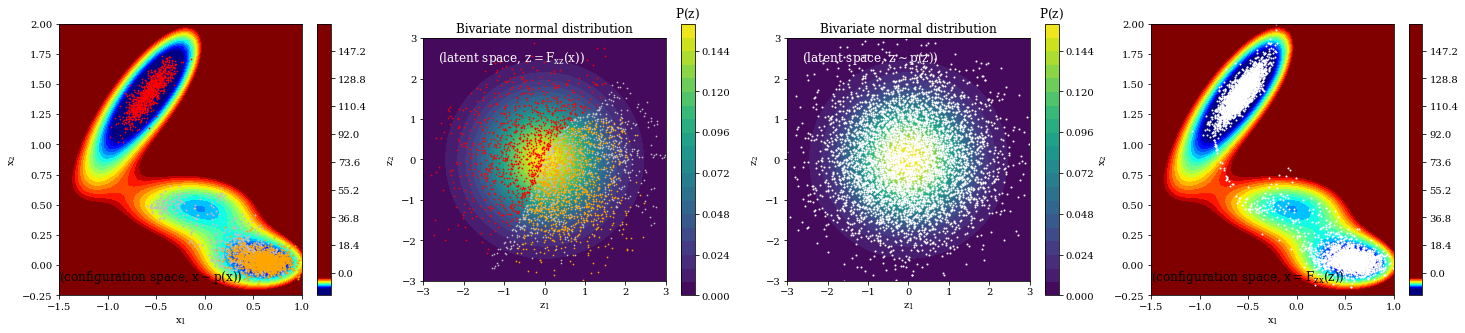

In [61]:
fig = plt.subplots(1, 4, figsize=(25, 5))

# First subplot: samples drawn from the configuration space
plt.subplot(1, 4, 1)
visuals.plot_2D_potential(muller.get_energy, xlim = [-1.5, 1], ylim = [-0.25, 2], cmap='jet')
plt.scatter(xy_mp1[:, 0], xy_mp1[:, 1], color='red', s=0.5)
plt.scatter(xy_mp2[:, 0], xy_mp2[:, 1], color='silver', s=1)
plt.scatter(xy_mp3[:, 0], xy_mp3[:, 1], color='orange', s=1)
plt.annotate('(configuration space, $ x \sim p(x) $)', xy=(0, 0), xytext=(-1.5, -0.125), color='black', size='12')
ax = plt.gca()
plt.xlim([-1.5,1])


# Second subplot: transform configuration samples to latent samples using a trained inversed generator
z1 = model_MLKLRC.inverse_generator(torch.from_numpy(xy_mp1.astype('float32')))[0].detach().numpy()
z2 = model_MLKLRC.inverse_generator(torch.from_numpy(xy_mp2.astype('float32')))[0].detach().numpy()
z3 = model_MLKLRC.inverse_generator(torch.from_numpy(xy_mp3.astype('float32')))[0].detach().numpy()


plt.subplot(1, 4, 2)
binormal_contour()
plt.scatter(z1[:, 0], z1[:, 1], color='red', s=0.5)
plt.scatter(z2[:, 0], z2[:, 1], color='silver', s=0.5)
plt.scatter(z3[:, 0], z3[:, 1], color='orange', s=0.5)
plt.annotate('(latent space, $ z = F_{xz}(x) $)', xy=(0, 0),  xytext=(-2.625, 2.4375), color='white', size='12')
plt.xlim([-3, 3])
plt.ylim([-3, 3])


# Third subplot: draw 2000 samples from the prior Gaussian distribution
z_samples = model_MLKLRC.prior.sample_n(5000)
z_samples = z_samples.detach().numpy()  

plt.subplot(1, 4, 3)
binormal_contour()
plt.scatter(z_samples[:, 0], z_samples[:, 1], color='white', s=1)
plt.annotate('(latent space, $ z \sim p(z) $)', xy=(0, 0), xytext=(-2.625, 2.4375), color='white', size='12')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.ylim([-3, 3])

# fourth subplot: transform the latent samples back to the configuration space using a generator
x_generated, log_R_zx = model_MLKLRC.generator(torch.from_numpy(z_samples))
x_generated = x_generated.detach().numpy()

plt.subplot(1, 4, 4)
visuals.plot_2D_potential(muller.get_energy, xlim = [-1.5, 1], ylim = [-0.25, 2], cmap='jet')
plt.scatter(x_generated[:, 0], x_generated[:, 1], color='white', s=1)
plt.annotate('(configuration space, $ x = F_{zx}(z) $)', xy=(0, 0),  xytext=(-1.5, -0.125), color='black', size='12')
plt.xlim([-1.5,1])
plt.ylim([-0.25, 2])
ax = plt.gca()

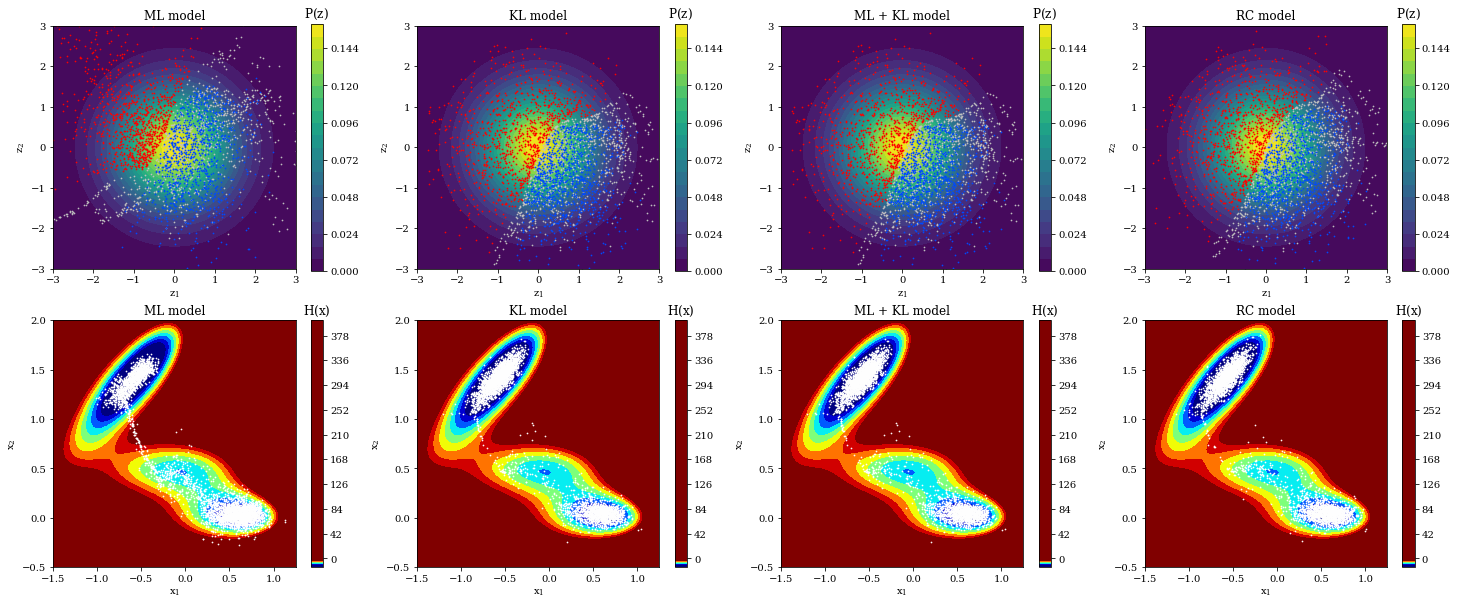

In [116]:
BoltzmannPlotter_MLKLRC.all_generated_samples('../Project/Pictures/MBP_all_generated_samples.png', generators=[model_ML, model_KL, model_MLKL, model_MLKLRC], n_z=5000)

## Free Energy Calculation

## ML + KL Model

In [30]:
z_f = model_MLKL.prior.sample_n(50000)
x_f, log_R_zx = model_ML.generator((z_f))
x_f = x_f.detach().numpy()

u_x = model_ML.calculate_energy(torch.from_numpy(x_f), space='configuration')
u_mlkl = u_x
u_z = model_ML.calculate_energy(z_f, space='latent')
w = torch.exp(-u_x + u_z + log_R_zx)
w = w.detach().numpy()

(-15, 0)

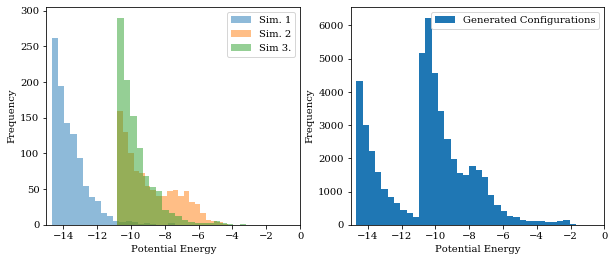

In [21]:
fig, ax = plt.subplots(ncols=2, figsize=[10,4])
# hist1 = ax[0].hist(all_energy_mp, bins = 40)
ax[0].hist(system_mp1.etraj, bins = 20, alpha = 0.5)
ax[0].hist(system_mp2.etraj, bins = 20, alpha = 0.5)
ax[0].hist(system_mp3.etraj, bins = 20, alpha = 0.5)
ax[0].set_xlabel("Potential Energy")
ax[0].set_ylabel("Frequency")
ax[0].set_xlim([-15, 0])
ax[0].legend(["Sim. 1", "Sim. 2", "Sim 3."])

ax[1].hist(u_x, bins = 50)
ax[1].set_xlabel("Potential Energy")
ax[1].set_ylabel("Frequency")
ax[1].legend(["Generated Configurations"])
ax[1].set_xlim([-15, 0])

/home/lenny/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/home/lenny/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


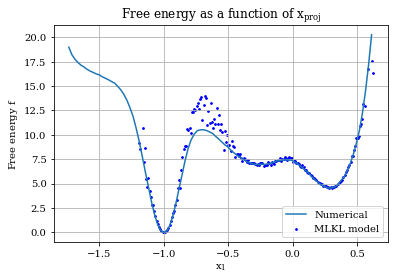

In [22]:
x_proj = np.dot(x_f, np.array([1, -1]))/np.dot(np.array([1,-1]),np.array([1,-1]))
counts, bins = np.histogram(x_proj, bins=200, weights=w)
probs = counts / np.sum(counts)  # p_x(x)
centers = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])  # x

f = -np.log(probs)
f -= np.min(f)

plt.figure()
plt.scatter(centers, f, color = "blue", s = 3)
plt.xlabel("$x_{1}$")
plt.ylabel("Free energy $f$")
plt.title("Free energy as a function of $x_{proj}$")
plt.grid()
#doublewell.plot_section(y=0)

f = -np.log(probs)
fn = f - np.min(f)

# Approximation of muller potential FE
x = np.linspace(-1.5, 1.0, 100)
y = np.linspace(-0.25, 2, 100)
X, Y = np.meshgrid(x,y)
x_vector = X.flatten()
y_vector = Y.flatten()

E_vector = []
x_traj_v = []
for x,y in zip(x_vector, y_vector):
    E_vector.append(muller.get_energy(np.array([x,y])))
    x_traj_v.append(np.dot(np.array([x,y]), np.array([1, -1]))/np.dot(np.array([1,-1]),np.array([1,-1])))

E_vector = np.array(E_vector)
x_traj_v = np.array(x_traj_v)

counts_anlyt, bins_anlyt = np.histogram(x_traj_v, weights=np.exp(-E_vector), bins=100)
probs_anlyt = counts_anlyt / np.sum(counts_anlyt)
centers_anlyt = np.array([0.5 * (bins_anlyt[i] + bins_anlyt[i + 1]) for i in range(len(bins_anlyt) - 1)])  # x

f_anlyt = -np.log(probs_anlyt)
f_anlyt -= np.min(f_anlyt)

plt.plot(centers_anlyt, f_anlyt)
plt.legend(["Numerical", "MLKL model"])

## ML KL RC Loss

/home/lenny/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/home/lenny/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log


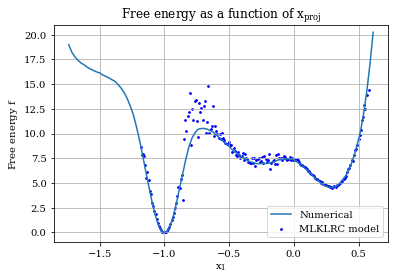

In [119]:
z_f = model_ML.prior.sample_n(50000)
x_f, log_R_zx = model_MLKLRC.generator((z_f))
x_f = x_f.detach().numpy()

u_x = model_MLKLRC.calculate_energy(torch.from_numpy(x_f), space='configuration')
u_mlklrc = u_x
u_z = model_MLKLRC.calculate_energy(z_f, space='latent')
w = torch.exp(-u_x + u_z + log_R_zx)
w = w.detach().numpy()

x_proj = np.dot(x_f, np.array([1, -1]))/np.dot(np.array([1,-1]),np.array([1,-1]))
counts, bins = np.histogram(x_proj, bins=200, weights=w)
probs = counts / np.sum(counts)  # p_x(x)
centers = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])  # x

f = -np.log(probs)
f -= np.min(f)

plt.figure()
plt.scatter(centers, f, color = "blue", s = 3)
plt.xlabel("$x_{1}$")
plt.ylabel("Free energy $f$")
plt.title("Free energy as a function of $x_{proj}$")
plt.grid()
#doublewell.plot_section(y=0)

f = -np.log(probs)
fn = f - np.min(f)

# Approximation of muller potential FE
x = np.linspace(-1.5, 1.0, 100)
y = np.linspace(-0.25, 2, 100)
X, Y = np.meshgrid(x,y)
x_vector = X.flatten()
y_vector = Y.flatten()

E_vector = []
x_traj_v = []
for x,y in zip(x_vector, y_vector):
    E_vector.append(muller.get_energy(np.array([x,y])))
    x_traj_v.append(np.dot(np.array([x,y]), np.array([1, -1]))/np.dot(np.array([1,-1]),np.array([1,-1])))

E_vector = np.array(E_vector)
x_traj_v = np.array(x_traj_v)

counts_anlyt, bins_anlyt = np.histogram(x_traj_v, weights=np.exp(-E_vector), bins=100)
probs_anlyt = counts_anlyt / np.sum(counts_anlyt)
centers_anlyt = np.array([0.5 * (bins_anlyt[i] + bins_anlyt[i + 1]) for i in range(len(bins_anlyt) - 1)])  # x

f_anlyt = -np.log(probs_anlyt)
f_anlyt -= np.min(f_anlyt)

plt.plot(centers_anlyt, f_anlyt)
plt.ylim([-1, 21])
plt.legend(["Numerical", "MLKLRC model"])

## ML Loss

/home/lenny/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/home/lenny/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log


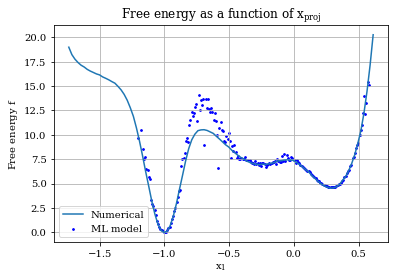

In [27]:
z_f = model_ML.prior.sample_n(50000)
x_f, log_R_zx = model_ML.generator((z_f))
x_f = x_f.detach().numpy()

u_x = model_ML.calculate_energy(torch.from_numpy(x_f), space='configuration')
u_ml = u_x
u_z = model_ML.calculate_energy(z_f, space='latent')
w = torch.exp(-u_x + u_z + log_R_zx)
w = w.detach().numpy()

x_proj = np.dot(x_f, np.array([1, -1]))/np.dot(np.array([1,-1]),np.array([1,-1]))
counts, bins = np.histogram(x_proj, bins=200, weights=w)
probs = counts / np.sum(counts)  # p_x(x)
centers = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])  # x

f = -np.log(probs)
f -= np.min(f)

plt.figure()
plt.scatter(centers, f, color = "blue", s = 3)
plt.xlabel("$x_{1}$")
plt.ylabel("Free energy $f$")
plt.title("Free energy as a function of $x_{proj}$")
plt.grid()
#doublewell.plot_section(y=0)

f = -np.log(probs)
fn = f - np.min(f)

x_data = np.linspace(-1.2, 0.8, 200)
y_data = -x_data + 0.5
xy_data = np.array([x_data, y_data]).T
x_proj = np.dot(xy_data, np.array([1, -1]))/np.dot(np.array([1,-1]),np.array([1,-1]))

f_analyticals = []
for x,y in zip(x_data, y_data):
    f_analytical = muller.get_energy(np.array([x,y])) - np.log(np.sqrt(np.pi))
    f_analytical += 13.75
    
    f_analyticals.append(f_analytical)

plt.plot(centers_anlyt, f_anlyt)
plt.legend(["Numerical", "ML model"])

## KL Loss

/home/lenny/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/home/lenny/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log


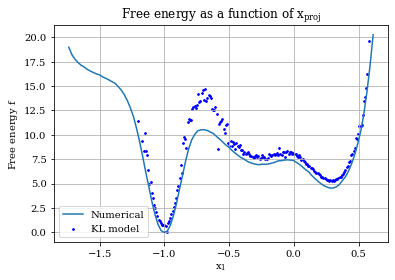

In [24]:
z_f = model_KL.prior.sample_n(50000)
x_f, log_R_zx = model_ML.generator((z_f))
x_f = x_f.detach().numpy()

u_x = model_ML.calculate_energy(torch.from_numpy(x_f), space='configuration')
u_kl = u_x
u_z = model_ML.calculate_energy(z_f, space='latent')
w = torch.exp(-u_x + u_z + log_R_zx)
w = w.detach().numpy()

x_proj = np.dot(x_f, np.array([1, -1]))/np.dot(np.array([1,-1]),np.array([1,-1]))
counts, bins = np.histogram(x_proj, bins=200, weights=w)
probs = counts / np.sum(counts)  # p_x(x)
centers = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])  # x

f = -np.log(probs)
f -= np.min(f)

plt.figure()
plt.scatter(centers, f, color = "blue", s = 3)
plt.xlabel("$x_{1}$")
plt.ylabel("Free energy $f$")
plt.title("Free energy as a function of $x_{proj}$")
plt.grid()
#doublewell.plot_section(y=0)

f = -np.log(probs)
fn = f - np.min(f)

x_data = np.linspace(-1.2, 0.8, 200)
y_data = -x_data + 0.5
xy_data = np.array([x_data, y_data]).T
x_proj = np.dot(xy_data, np.array([1, -1]))/np.dot(np.array([1,-1]),np.array([1,-1]))

f_analyticals = []
for x,y in zip(x_data, y_data):
    f_analytical = muller.get_energy(np.array([x,y])) - np.log(np.sqrt(np.pi))
    f_analytical += 13.75
    
    f_analyticals.append(f_analytical)

plt.plot(centers_anlyt, f_anlyt)
plt.legend(["Numerical", "KL model"])

In [25]:
x_data = np.linspace(-1.2, 0.8, 200)
y_data = -x_data + 0.5
xy_data = np.array([x_data, y_data]).T
x_proj = np.dot(xy_data, np.array([1, -1]))/np.dot(np.array([1,-1]),np.array([1,-1]))

U = [muller.get_energy(np.array([a,b])) for a,b in zip(x_data, y_data)]

(-15, 0)

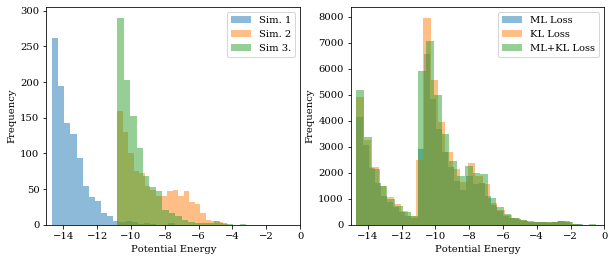

In [33]:
fig, ax = plt.subplots(ncols=2, figsize=[10,4])
# hist1 = ax[0].hist(all_energy_mp, bins = 40)
ax[0].hist(system_mp1.etraj, bins = 20, alpha = 0.5)
ax[0].hist(system_mp2.etraj, bins = 20, alpha = 0.5)
ax[0].hist(system_mp3.etraj, bins = 20, alpha = 0.5)
ax[0].set_xlabel("Potential Energy")
ax[0].set_ylabel("Frequency")
ax[0].set_xlim([-15, 0])
ax[0].legend(["Sim. 1", "Sim. 2", "Sim 3."])

ax[1].hist(u_ml, bins = 50, alpha = 0.5)
ax[1].hist(u_kl, bins = 50, alpha = 0.5)
ax[1].hist(u_mlkl, bins = 50, alpha = 0.5)
ax[1].set_xlabel("Potential Energy")
ax[1].set_ylabel("Frequency")
ax[1].legend(["ML Loss", "KL Loss", "ML+KL Loss"])
ax[1].set_xlim([-15, 0])